<h1>Preicting breast cancer mortality</h1>
<h4><i>Binary classifiers are optimized to predict breast cancer mortality from clinical and genetic features.</i></h4>
<h4><br></h4>
<h2>Introduction</h2>

Genetic variation is a key factor in breast cancer, as cancer type, response to treatment, and disease progression are genetically controlled. For example, BRCA1 and BRCA2 genetic mutations diminish the ability of proteins to repair damaged DNA, which causes abnormal cell growth and cancer. A full understanding of the genetic underpinnings of cancer would enable scientists to develop effective treatments for each target and clinicians to select optimal treatment strategies. 

In this project, we extract the most important genes for predicting cancer patient mortality. Because mortality is also influenced by intrinsic factors, like patient age and disease stage at diagnosis, intrinsic factors are considered with genetic factors to reduce model bias. Survival time and cause of death are considered outcomes and are not used to predict overall patient mortality. The performance of linear, SVM, and tree-based models is evaluated on the basis of accuracy, but full consideration is given to precision, recall, F1 score and the receiver operating characteristic area under the curve (ROC AUC). The top performing models of each type are combined into a voting classifier, which can be used to predict patient mortality with 73.4% accuracy. 

Permutation importance is used to extract the importance of each feature. The most important intrinsic factor to our model is patient age at diagnosis. Several genetic features emerge as the most indicative of patient death in our model. These include CASP8, STAT5A, JAK1 and NOTCH3. The effect of specific mutations type was not explored as there is insufficient data, but a simplified analysis of wild vs. mutated status revealed five significant genes GATA3, TP53, LAMA2, PIK3CA and RYR2 that when mutated are known to underly unfavorable patient outcomes. The known importance of the key genes identified by our classifier supports the validity of our model. Further insight may come from analysis of middle-ranking genes that may still be important to specific cancer subtypes. More data would enable the identification of specific mutations that may play an important role in breast cancer patient outcome.  

## Data cleaning

### Importing data 
The Molecular Taxonomy of Breast Cancer International Consortium (METABRIC) database is imported from [Kaggle](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric). The METABRIC database is a Canada-UK Project which contains targeted sequencing data of 1,980 primary breast cancer samples originally downloaded from [cBioPortal](https://www.cbioportal.org/). 

In [432]:
import pandas as pd
import os
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV 
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from operator import itemgetter
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, precision_score,f1_score, roc_auc_score, recall_score, mean_squared_error

In [433]:
os.chdir('C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\breast_cancer')
os.getcwd()

'C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\breast_cancer'

In [434]:
pd.options.display.max_columns = 100

In [435]:
def import_csv(csv_loc):
    df = pd.read_csv(csv_loc,low_memory=False)
    return df

In [436]:
csv_loc = 'METABRIC_RNA_Mutation.csv'

### Dropping nan values

In [437]:
#findind nan values
df.isna().sum().sort_values(ascending=False)[:10]

age_at_diagnosis    0
ptpn22              0
rasgef1b            0
rpgr                0
ryr2                0
sbno1               0
setd1a              0
setd2               0
setdb1              0
sf3b1               0
dtype: int64

In [438]:
#deleting columns that aren't of particular interest and have many nan entries
def drop_nan(df): 

    #deleting rows with low interest information and high NaN counts
    print(f'df shape before NaN drop: {df.shape}')
    del df['cellularity']
    del df['neoplasm_histologic_grade']
    del df['primary_tumor_laterality']
    del df['er_status_measured_by_ihc']
    df = df.dropna()
    print(f'df shape after NaN drop: {df.shape}')

    # in cancer_type feature, one instance of Breast Sarcoma was deleted
    # feature now only contains one value and is therefore removed 
    df.pop('cancer_type')

    #we also don't need patient id 
    df.pop('patient_id')
    return df

### Encoding data

In [439]:
#encoding data
def encode(df):
    print(f'Shape before encoding: {df.shape}')
    #encoding features with 2 values
    df = pd.get_dummies(df, columns=['type_of_breast_surgery','er_status','inferred_menopausal_state','pr_status','her2_status'], drop_first=True)

    #encoding other features with >2 values
    df = pd.get_dummies(df, columns=['3-gene_classifier_subtype','death_from_cancer','cancer_type_detailed','pam50_+_claudin-low_subtype','cohort','integrative_cluster','oncotree_code','her2_status_measured_by_snp6','tumor_other_histologic_subtype'])
    
    #encode wild type (0) or general mutant type (1)
    for col in df.columns:
        if 'mut' in col:
            df[col]=np.where((df[col])!='0',1,0)
    
    #removing mutant features with less than 30 positive instances 
    for col in df.columns:
        if 'mut' in col:
            if sum(df[col]) < 30:
                del df[col]
    
    return df

    print(f'Shape after encoding: {df.shape}')

In [440]:
#switching 0 and 1 so that 1 predicts death and 0 predicts survival
def kill_switch(df):
    df['overall_survival']=np.where(df['overall_survival']==0,1,0)
    return df

### Removing outliers

We calculate the z-score for each feature and examine the features with high z-score instances. Some categorical columns indeed contain outliers from data entry. In reviewing the gene expression data, the samples identified as outliers are not clear outliers and may represent high or low levels of expression from distinct, cancer-causing phenotypes. Thus, only the categorical outliers are removed.  


In [441]:
#finding outliers
#we look through non-binary data to find outliers 
#looking through this list it does indeed appear that the categorical columns identified contain outliers 
#The gene expression values are more ambigous 
print('Features with the highes member zscores:')
stats.zscore(df, axis=0).max(axis=0).sort_values(ascending=False)[:10]

Features with the highes member zscores:


her2_status_measured_by_snp6_UNDEF    19.824228
nrg3                                  16.173489
gh1                                   15.158937
ush2a                                 15.147913
slco1b3                               14.974030
itgb3                                 14.872653
inha                                  14.551166
bmp3                                  13.893939
magea8                                13.232305
myo1a                                 12.818764
dtype: float64

In [442]:
#outliers with a z score above 20 are removed 
#this conservative approach is taken in order to only remove outliers from categorical data
#high gene expression levels could be a result of cancer causing phenotypes that are indeed different from the mean distribution and not outliers

def zscore_drop(df):
    zscore = stats.zscore(df, axis=0)
    print(f'Shape before outlier removal:{df.shape}')
    df[zscore>20]=np.nan
    df.dropna(inplace=True)
    print(f'Shape after outlier removal:{df.shape}')
    return df

### Scaling data

Non-binary data is scalled using the StandardScaler transformer. 

In [443]:
def scale(df):
    #selecting features that will be scaled 
    to_scale = [col for col in df if df[col].unique().shape[0] > 2]
    not_scaled = [col for col in df if df[col].unique().shape[0] <= 2]

    #copying selected unscaled data for EDA
    df_unscaled = pd.DataFrame()
    df_unscaled['survival_months'] = df['overall_survival_months'].copy()
    df_unscaled['age'] = df['age_at_diagnosis'].copy()
    df_unscaled['tumor_stage'] = df['tumor_stage'].copy()
    df_unscaled['overall_survival']=df['overall_survival'].copy()
    df_unscaled['nott']=df['nottingham_prognostic_index'].copy()
    df_unscaled['tumor_size']=df['tumor_size'].copy()

    #normalizing features 
    #I believe I have found a glitch with column transformer using dataframes and passthrough
    #passthrough is not honored and all columns are transformed 
    #thus, column transformer is not used and columns are manually transformed

    #transforming to_scale columns
    scaler = StandardScaler()
    df_transformed = df[to_scale]
    col_names = df_transformed.columns.values
    df_transformed = scaler.fit_transform(df_transformed)
    df_transformed = pd.DataFrame(df_transformed,columns=col_names)

    #isolating passthrough columns
    df_pass = df[not_scaled]

    #concatenating df
    df = pd.concat([df_transformed.reset_index(drop=True), df_pass.reset_index(drop=True)],axis=1)

    return df, df_unscaled


<h3>Cleaning data</h3>

In [444]:
class clean():
    def __init__(self,csv_location):
        self.csv = csv_loc

    def __call__(self):
        print('Importing data...')
        df = import_csv(csv_loc)
        print('Droping NaNs...')
        df = drop_nan(df)
        print('Encoding data...')
        df = encode(df)
        df = kill_switch(df)
        print('Removing outliers...')
        df = zscore_drop(df)
        print('Rescaling data...')
        df, df_unscaled = scale(df)
        return df, df_unscaled

In [445]:
df, df_unscaled = clean(csv_loc)()

Importing data...
Droping NaNs...
df shape before NaN drop: (1904, 693)
df shape after NaN drop: (1185, 689)
Encoding data...
Shape before encoding: (1185, 687)


Removing outliers...
Shape before outlier removal:(1185, 610)
Shape after outlier removal:(1182, 610)
Rescaling data...


In [446]:
df.head()

,age_at_diagnosis,lymph_nodes_examined_positive,nottingham_prognostic_index,overall_survival_months,tumor_size,tumor_stage,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,rad50,rb1,rbl1,rbl2,ccna1,ccnb1,cdk1,ccne1,cdk2,cdc25a,ccnd1,cdk4,cdk6,ccnd2,cdkn2a,cdkn2b,myc,cdkn1a,cdkn1b,e2f1,e2f2,e2f3,e2f4,e2f5,e2f6,...,3-gene_classifier_subtype_ER+/HER2- High Prolif,3-gene_classifier_subtype_ER+/HER2- Low Prolif,3-gene_classifier_subtype_ER-/HER2-,3-gene_classifier_subtype_HER2+,death_from_cancer_Died of Disease,death_from_cancer_Died of Other Causes,death_from_cancer_Living,cancer_type_detailed_Breast,cancer_type_detailed_Breast Invasive Ductal Carcinoma,cancer_type_detailed_Breast Invasive Lobular Carcinoma,cancer_type_detailed_Breast Invasive Mixed Mucinous Carcinoma,cancer_type_detailed_Breast Mixed Ductal and Lobular Carcinoma,pam50_+_claudin-low_subtype_Basal,pam50_+_claudin-low_subtype_Her2,pam50_+_claudin-low_subtype_LumA,pam50_+_claudin-low_subtype_LumB,pam50_+_claudin-low_subtype_NC,pam50_+_claudin-low_subtype_Normal,pam50_+_claudin-low_subtype_claudin-low,cohort_1.0,cohort_2.0,cohort_3.0,cohort_5.0,integrative_cluster_1,integrative_cluster_10,integrative_cluster_2,integrative_cluster_3,integrative_cluster_4ER+,integrative_cluster_4ER-,integrative_cluster_5,integrative_cluster_6,integrative_cluster_7,integrative_cluster_8,integrative_cluster_9,oncotree_code_BREAST,oncotree_code_IDC,oncotree_code_ILC,oncotree_code_IMMC,oncotree_code_MDLC,her2_status_measured_by_snp6_GAIN,her2_status_measured_by_snp6_LOSS,her2_status_measured_by_snp6_NEUTRAL,her2_status_measured_by_snp6_UNDEF,tumor_other_histologic_subtype_Ductal/NST,tumor_other_histologic_subtype_Lobular,tumor_other_histologic_subtype_Medullary,tumor_other_histologic_subtype_Mixed,tumor_other_histologic_subtype_Mucinous,tumor_other_histologic_subtype_Other,tumor_other_histologic_subtype_Tubular/ cribriform
0,-1.342325,-0.483607,-0.016111,-0.562389,-1.070008,-1.181296,-1.420635,0.261688,-1.286366,0.529531,0.003926,-0.277149,1.414253,0.866319,0.502742,-2.692766,0.650787,0.541399,1.249116,1.033877,0.218385,1.066392,0.637096,-0.425958,-0.287715,0.735041,-1.922830,0.468105,0.786211,-0.248453,-0.241267,0.369208,-0.605274,0.163754,-1.279581,1.150741,0.381371,-0.665490,-0.015788,0.250519,-0.178695,0.712840,0.381182,1.930123,-1.921726,-0.314525,-1.420813,0.999927,0.016633,-0.410280,...,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,1.265873,1.614094,1.819679,-1.122515,0.960685,0.410827,1.377891,-0.948881,-0.764178,0.200938,0.378820,0.388637,0.959554,1.010218,0.734317,-0.257673,-0.235792,0.738851,-0.451506,0.465114,0.943676,0.659453,0.385514,-0.286003,-0.137891,-0.759012,0.999824,1.924723,0.655957,-0.728263,0.341507,1.101355,-1.026667,1.593454,1.302279,0.140514,1.775517,0.935219,-1.137206,0.341580,0.629239,0.501566,1.492742,0.115922,-0.270413,0.477337,-0.403244,-0.351127,2.302328,1.140580,...,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
2,1.404853,-0.483607,0.021318,-1.557066,0.351477,3.595073,-0.430389,0.687272,0.730749,1.111922,-1.988087,0.932457,1.202950,0.865288,-1.046839,-0.764303,-0.298437,1.176623,-0.362654,0.771103,1.213226,-0.536181,0.371096,0.276789,-0.329990,-0.063089,0.848543,0.868741,0.525169,-0.019022,1.686683,1.598886,-0.381611,0.938061,0.533818,-0.832830,1.155668,-0.261239,-0.854267,-0.494676,-0.194860,-0.911417,-0.935615,0.347801,1.490798,1.062442,0.285635,-1.140846,-0.749567,0.130475,...,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0
3,1.994747,-0.221394,0.885743,-1.184655,-0.663869,0.410827,0.897895,-1.563488,0.363260,-0.609830,0.075798,-0.936842,-0.843959,-0.085578,-0.228525,0.730521,-0.977661,-0.502543,-0.115631,0.330623,-0.456746,2.262133,0.225020,1.077178,-1.917275,-1.045907,-0.654543,-0.712551,-0.968839,-0.174024,1.704029,0.967333,-0.550228,

## EDA

### Mortality

In [447]:
#constructs death classification column from encoded data
df_death = pd.from_dummies(df[df.columns[df.columns.str.contains('death_from_cancer')]])
df_death = df_death.replace({'death_from_cancer_Living':'Living','death_from_cancer_Died of Disease':'Cancer death','death_from_cancer_Died of Other Causes':'Other death'})

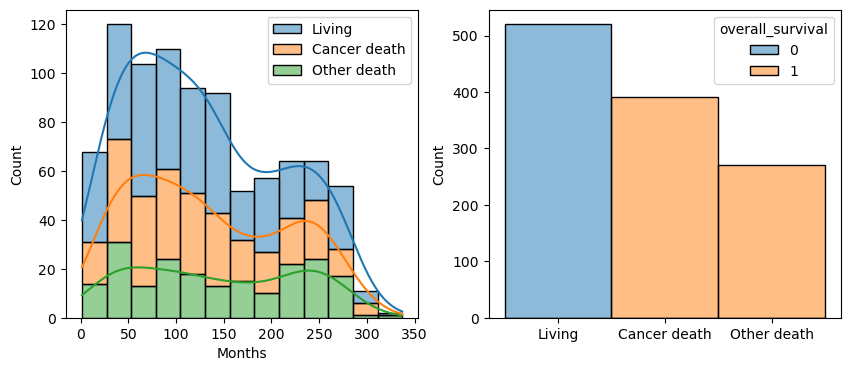

In [448]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x=df_unscaled['survival_months'],hue=df_death.iloc[:,0], multiple='stack',kde=True)
plt.xlabel('Months')

plt.subplot(1,2,2)
#plt.bar(x = ['Cancer death','Other Death','Living'], height=df[['death_from_cancer_Died of Disease','death_from_cancer_Died of Other Causes', 'death_from_cancer_Living']].sum())
sns.histplot(data=df_death, x=df_death.iloc[:,0], hue=df['overall_survival']);

The overall count of living, cancer-related and other deaths shows a bimodal distribution, with most deaths occurring at 50 and 250 months.  

In [449]:
#remove other death outcomes from dataset to focus on overall survival 
del df['death_from_cancer_Died of Disease']
del df['death_from_cancer_Died of Other Causes']
del df['death_from_cancer_Living']
del df['overall_survival_months']

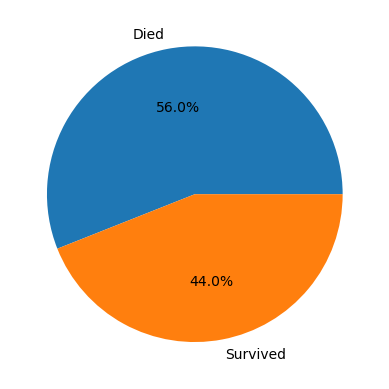

In [450]:
plt.pie(((sum(df['overall_survival']),df.shape[0]-sum(df['overall_survival']))),autopct='%1.1f%%',labels=['Died','Survived']);

The distribution of outcomes is skewed towards patient mortality. The imbalance is not of sufficient scale to warrant the implementation of naive random over-sampling or SMOTE.

### Age

<Axes: xlabel='age', ylabel='Count'>

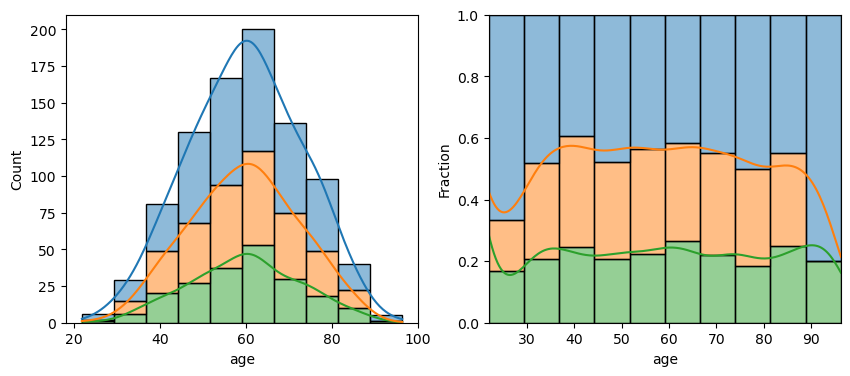

In [451]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,2)
sns.histplot(data=df, x=df_unscaled['age'],hue=df_death.iloc[:,0],kde=True, bins=10, multiple='fill', legend=False)
plt.ylabel('Fraction')
df_unscaled['death_by_age_percent'] = df_death
plt.subplot(1,2,1)
#sns.histplot(data=df, x=df_unscaled['age'],hue=df_death.iloc[:,0],kde=True, bins=10, multiple='stack')
sns.histplot(data=df, x=df_unscaled['age'],hue=df_death.iloc[:,0],kde=True, bins=10, multiple='stack', legend=False)


Cancer is more common in older populations and steadily increases from 20 to 60 years of age. The decrease observed in older populations is likely due to the underrepresentation of these subsets in the general population. Interestingly, the fraction of deaths in diagnosed cancers does not appear to be sensitive  to age after 30 years of age. 

### Cancer sub-type

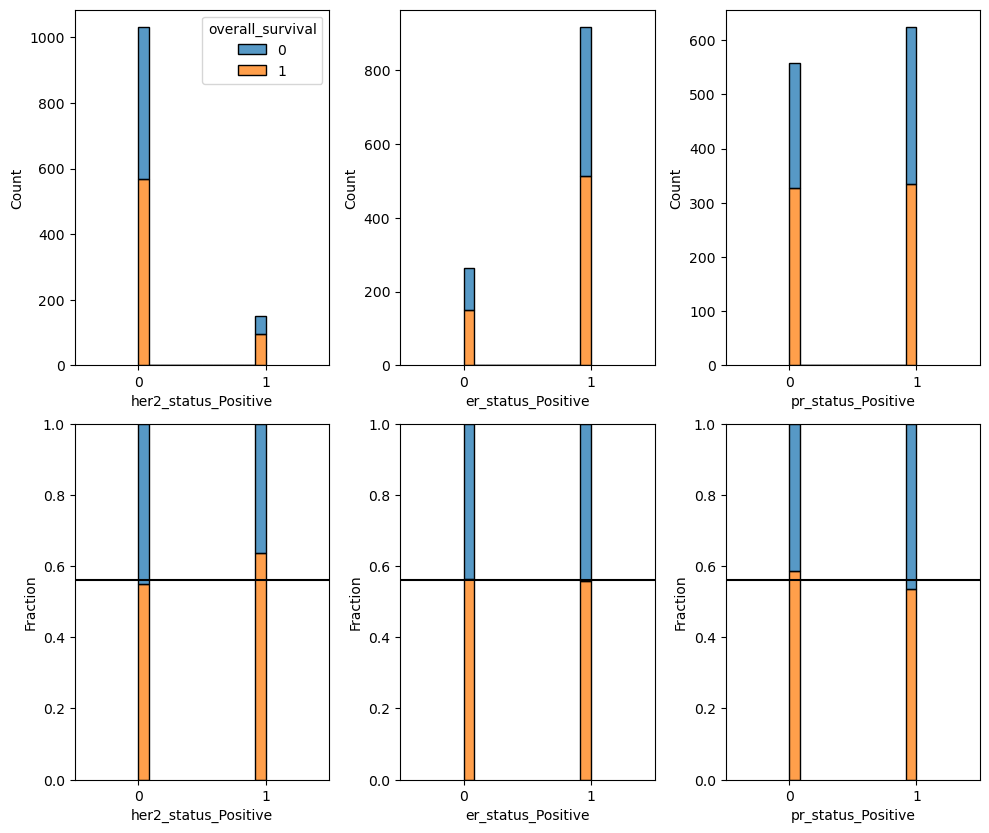

In [452]:
plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
sns.histplot(data=df.sort_values('her2_status_Positive'), x='her2_status_Positive',hue='overall_survival',multiple='stack')
plt.xticks((0,1))
plt.xlim((-.5,1.5))
plt.subplot(2,3,2)
sns.histplot(data=df.sort_values('er_status_Positive'), x='er_status_Positive', hue='overall_survival',multiple='stack',legend=False)
plt.xticks((0,1))
plt.xlim((-.5,1.5))
plt.tight_layout()
plt.subplot(2,3,3)
sns.histplot(data=df.sort_values('pr_status_Positive'), x='pr_status_Positive', hue='overall_survival',multiple='stack',legend=False)
plt.xticks((0,1))
plt.xlim((-.5,1.5))
plt.subplot(2,3,4)
sns.histplot(data=df.sort_values('her2_status_Positive'), x='her2_status_Positive',hue='overall_survival',multiple='fill', legend=False)
plt.xticks((0,1))
plt.xlim((-.5,1.5))
plt.ylabel('Fraction')
plt.axhline(.56,color='k')
plt.subplot(2,3,5)
sns.histplot(data=df.sort_values('er_status_Positive'), x='er_status_Positive', hue='overall_survival',multiple='fill',legend=False)
plt.xticks((0,1))
plt.ylabel('Fraction')
plt.axhline(.56,color='k')
plt.xlim((-.5,1.5))
plt.subplot(2,3,6)
sns.histplot(data=df.sort_values('pr_status_Positive'), x='pr_status_Positive', hue='overall_survival',multiple='fill',legend=False)
plt.xticks((0,1))
plt.xlim((-.5,1.5))
plt.axhline(.56,color='k')
plt.ylabel('Fraction');

We observe that HER2+ cancers have a higher than average mortality rate and are the most rare cancer subtype.

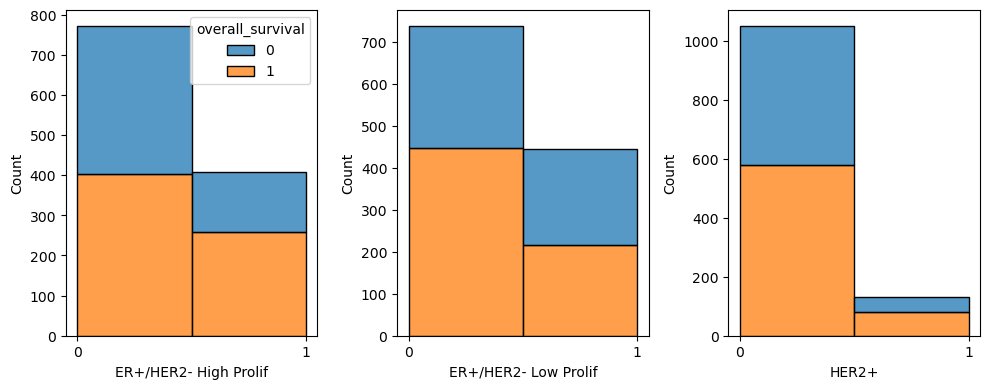

In [453]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
sns.histplot(df,x ='3-gene_classifier_subtype_ER+/HER2- High Prolif',  bins=2, hue='overall_survival', multiple='stack')
plt.xticks((0,1))
plt.xlabel('ER+/HER2- High Prolif')
plt.subplot(1,3,2)
sns.histplot(df,x ='3-gene_classifier_subtype_ER+/HER2- Low Prolif',  bins=2,  hue='overall_survival',legend=False, multiple='stack')
plt.xticks((0,1))
plt.xlabel('ER+/HER2- Low Prolif')
plt.subplot(1,3,3)
sns.histplot(df,x ='3-gene_classifier_subtype_HER2+',  bins=2,  hue='overall_survival', multiple='stack', legend=False)
plt.xticks((0,1))
plt.xlabel('HER2+')
plt.tight_layout()


### Cancer severity

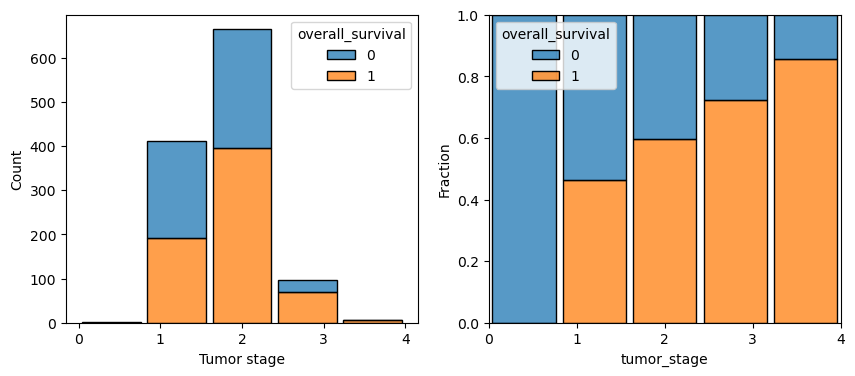

In [454]:
#histplot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(data=df_unscaled, x='tumor_stage', bins=5, hue='overall_survival',multiple='stack',shrink=.9)

plt.xlabel('Tumor stage')
plt.subplot(1,2,2)
sns.histplot(data=df_unscaled, x='tumor_stage' , bins=5, hue='overall_survival', multiple='fill',shrink=.9)
plt.xticks(np.arange(0,5))
plt.ylabel('Fraction');

Most tumors are diagnosed at stage 2, and the fraction of cancer-related mortalities increases with diagnosis stage, as expected. Clinical definition of cancer stage is given in the table below:

| Stage | Description |
| ----- | ---------------------------------------|
| 0 | Abnormal cells present with the potential to become cancer. |
| 1 | Cancer is only in the original location and has not spread into neighboring tissue. Surgery can normally remove the entire tumor. |
| 2 - 3 | Cancer is larger and has grown into nearby tissue or lymph nodes. |
| 4 | Advanced/metastatic cancer that has spread to other organs. |

Text(0, 0.5, 'Fraction')

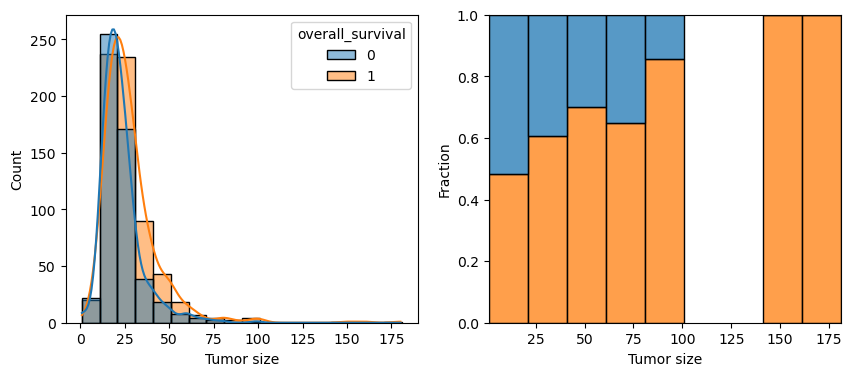

In [455]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(data=df_unscaled, x='tumor_size', binwidth=10, hue='overall_survival', legend=True, kde=True)
plt.xlabel('Tumor size')

plt.subplot(1,2,2)
sns.histplot(data=df_unscaled, x='tumor_size', binwidth=20, hue='overall_survival', legend=False, kde=False,multiple='fill')
plt.xlabel('Tumor size')
plt.ylabel('Fraction')

We see the size distribution of fatal cancers shifts towards larger tumor sizes. Also, we see the percentage of fatal cancers increase with tumor size.

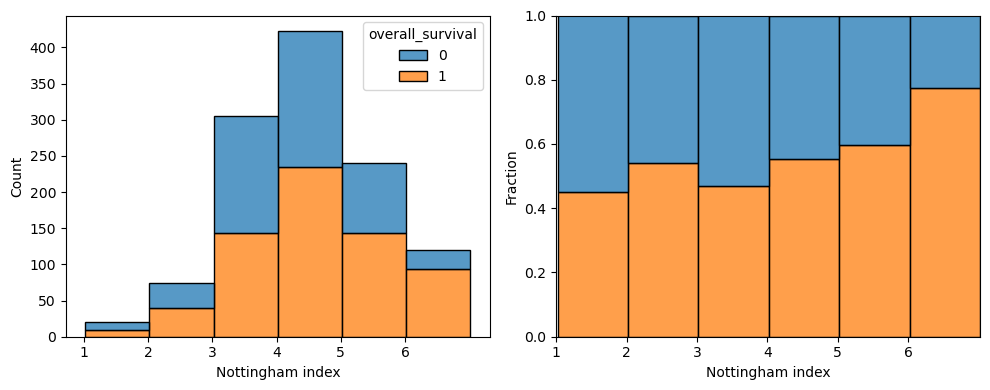

In [456]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(data=df_unscaled, x='nott',hue='overall_survival',binwidth=1,legend=True, multiple='stack')
plt.xlabel('Nottingham index')
plt.xticks(np.arange(1,7))

plt.subplot(1,2,2)
sns.histplot(data=df_unscaled, x='nott',hue='overall_survival',binwidth=1,legend=False, multiple='fill')
plt.xlabel('Nottingham index')
plt.ylabel('Fraction')
plt.xticks(np.arange(1,7))
plt.tight_layout()

The Nottingham Prognostic index is used to determine the prognosis following surgery for breast cancer and is based on three pathological criteria: size of the tumor, number of involved lymph nodes, and the grade of the tumor. We see that most breast cancers are a level 4 and that patient mortality increases with Nottingham index.

### Feature correlation to patient mortality

The Pearson correlation coefficient is calculated for all features with overall survival. There is a weak correlation between some expected clinical features and genes. We identify CDKN2C, HSD17B11, JAK1, CASP8, MYC, LAMA2, and SPRY 2 as helpful and NCOA3, GSK3b, KMT2C, TSC2 and MAMl1 as deleterious to patient survival. NCOA3 is overexpressed in 60% of primary human breast tumors and associated with drug resistance \[[1](https://pubmed.ncbi.nlm.nih.gov/15788663/)\]. Thus, its notable correlation with patient mortality is not surprising. Similarly, expression of CDKN2C has been found to be significantly lower in in breast tumor samples compared with control samples \[[2](https://www.sciencedirect.com/science/article/abs/pii/S2773044122000444)\].

In [457]:
print('Top 15 features correlated with survival:')
df.corr(numeric_only=True)['overall_survival'].sort_values()[:15]

Top 15 features correlated with survival:


cdkn2c                          -0.211885
hsd17b11                        -0.207751
jak1                            -0.193702
casp8                           -0.187504
myc                             -0.179950
lama2                           -0.178204
cohort_1.0                      -0.177976
inferred_menopausal_state_Pre   -0.177439
spry2                           -0.171490
stat5a                          -0.161958
tgfbr2                          -0.160153
igf1                            -0.159679
kit                             -0.154889
rheb                            -0.153300
mapk14                          -0.152612
Name: overall_survival, dtype: float64

In [458]:
print('Top 10 features correlated with death:')
df.corr(numeric_only=True)['overall_survival'].sort_values(ascending=False)[1:16]

Top 10 features correlated with death:


age_at_diagnosis                     0.309256
cohort_3.0                           0.210642
tumor_size                           0.170795
ncoa3                                0.169430
type_of_breast_surgery_MASTECTOMY    0.169163
lymph_nodes_examined_positive        0.168063
tumor_stage                          0.167757
gsk3b                                0.167004
kmt2c                                0.154626
tsc2                                 0.148509
nottingham_prognostic_index          0.147213
maml1                                0.137035
akt1                                 0.135464
afdn                                 0.134755
nf1                                  0.130849
Name: overall_survival, dtype: float64

In [459]:
import pickle 
pickle.dump(df, open('clean_cancer_data.pickle','wb'))

## Predicting patient mortality
### Test and train sets


In [460]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)

X_train, y_train = train_set.drop(columns=['overall_survival']), train_set['overall_survival']
X_test, y_test = test_set.drop(columns=['overall_survival']), test_set['overall_survival']

In [461]:
pickle.dump([X_train, y_train, X_test, y_test], open('test_train_cancer_data.pickle','wb'))

### Building classification models

Several models are optimized manually, including three logistic regression models using ridge, lasso, and elastic net regularization techniques; two support vector machines classification models using linear and sigmoid kerels (the sigmoid kernel was the best performing non-linear model); a random forest model; and an extra trees model. The best performing model of each type was selected for further performance analysis.

In [462]:
def model_score(X_train,y_train,X_test,y_test):

    #selecting models 
    log_mod = LogisticRegression(max_iter=10000,random_state=10, C=0.01).fit(X_train, y_train) 
    lasso_mod = LogisticRegression(max_iter=1000,penalty='l1',C=.15,solver='saga',random_state=10).fit(X_train, y_train)
    elastic_mod = LogisticRegression(max_iter=10000,C=.2,penalty='elasticnet',l1_ratio=0.2,solver='saga', random_state=10).fit(X_train, y_train)
    svm_mod = LinearSVC(random_state=10,max_iter=10000, C=.001).fit(X_train, y_train)
    svm_kernel = SVC(kernel='sigmoid', random_state=10, max_iter=10000, gamma='scale').fit(X_train, y_train)
    rf = RandomForestClassifier(n_estimators=700,random_state=10, ).fit(X_train,y_train)
    et = ExtraTreesClassifier(n_estimators=700, random_state=10).fit(X_train, y_train)

    models = [log_mod,lasso_mod,elastic_mod,svm_mod,svm_kernel, rf, et]
    #models = [elastic_mod, svm_kernel, rf, et]
    model_names = [type(model).__name__ for model in models]
    #scoring models
    accuracy = []
    precision = []
    recall = []
    f1 = []
    roc_auc = []

    for model in models:
        y_predict = model.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_predict))
        precision.append(precision_score(y_test, y_predict))
        f1.append(f1_score(y_test, y_predict))
        roc_auc.append(roc_auc_score(y_test, y_predict))
        recall.append(recall_score(y_test, y_predict))

    scores = pd.DataFrame([accuracy, precision, recall, f1, roc_auc],columns=model_names,index=['accuracy','precision','recall','f1','roc_auc']).T

    return models,model_names,scores



In [463]:
models, model_names, scores = model_score(X_train,y_train,X_test,y_test)

In [464]:
scores

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.721519,0.730496,0.786260,0.757353,0.713884
LogisticRegression,0.704641,0.719424,0.763359,0.740741,0.697717
LogisticRegression,0.704641,0.736434,0.725191,0.730769,0.702218
LinearSVC,0.729958,0.737589,0.793893,0.764706,0.722418
SVC,0.721519,0.724138,0.801527,0.760870,0.712084
RandomForestClassifier,0.704641,0.680473,0.877863,0.766667,0.684214
ExtraTreesClassifier,0.721519,0.709677,0.839695,0.769231,0.707583


In [465]:
select_scores = scores.reset_index().drop([1,2,4]).set_index('index')
select_scores

,accuracy,precision,recall,f1,roc_auc
index,,,,,
LogisticRegression,0.721519,0.730496,0.786260,0.757353,0.713884
LinearSVC,0.729958,0.737589,0.793893,0.764706,0.722418
RandomForestClassifier,0.704641,0.680473,0.877863,0.766667,0.684214
ExtraTreesClassifier,0.721519,0.709677,0.839695,0.769231,0.707583


In [466]:
selected_models = itemgetter(0,3,5,6)(models)
print('Selected model details:')
selected_models

Selected model details:


(LogisticRegression(C=0.01, max_iter=10000, random_state=10),
 LinearSVC(C=0.001, max_iter=10000, random_state=10),
 RandomForestClassifier(n_estimators=700, random_state=10),
 ExtraTreesClassifier(n_estimators=700, random_state=10))

In [467]:
pickle.dump(selected_models[1], open('svc_cancer_model.pickle','wb'))

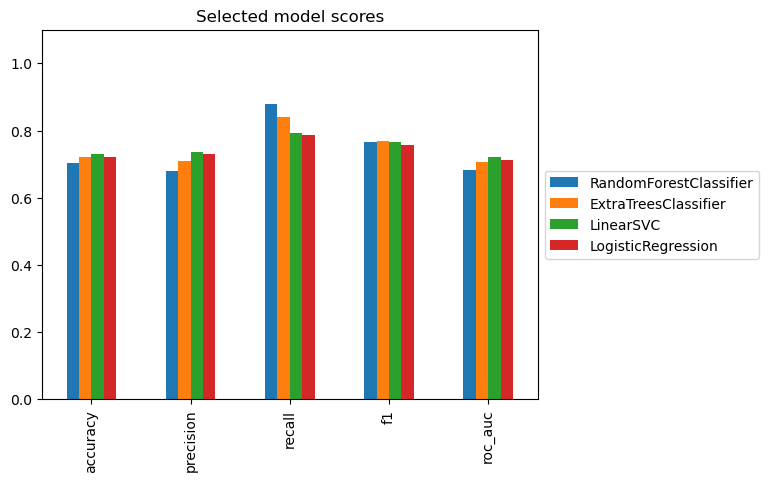

In [468]:
ax = select_scores.sort_values('recall', ascending=False).T.plot(kind='bar')
plt.ylim((0,1.1))
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Selected model scores');

Accuracy, precision, recall, f1 score, and ROC AUC are evaluated for the selected models, and are defined below as functions of true positive (TP), true negative (TN), false positive (FP) and false negative (FN) predictions:

![](https://www.tutorialexample.com/wp-content/uploads/2022/01/how-to-compute-accuracy-precision-recall-and-f1-score-in-machine-learning.png)

Accuracy indicates how many cases were correctly predicted and is a good overall indicator of model performance, especially as the METABRIC dataset is relatively balanced. Precision indicates the ratio of correctly predicted positive cases to all positive cases, and recall indicates the ratio of all the correctly identified positive cases divided by all true positive cases. It would not serve researchers to have an overly precise model that misses many patient deaths, nor would it be helpful to over-predict death to prevent missing a few cases. The F1 score is a more balanced indicator, but was very similar for all models. Thus, accuracy was used to select models.

We see the effect of threshold on model performance in the below figures, which show precession and recall with threshold directly and recall (or true positive rate) against false positive rate (FP/(FP+FN)) at different thresholds.

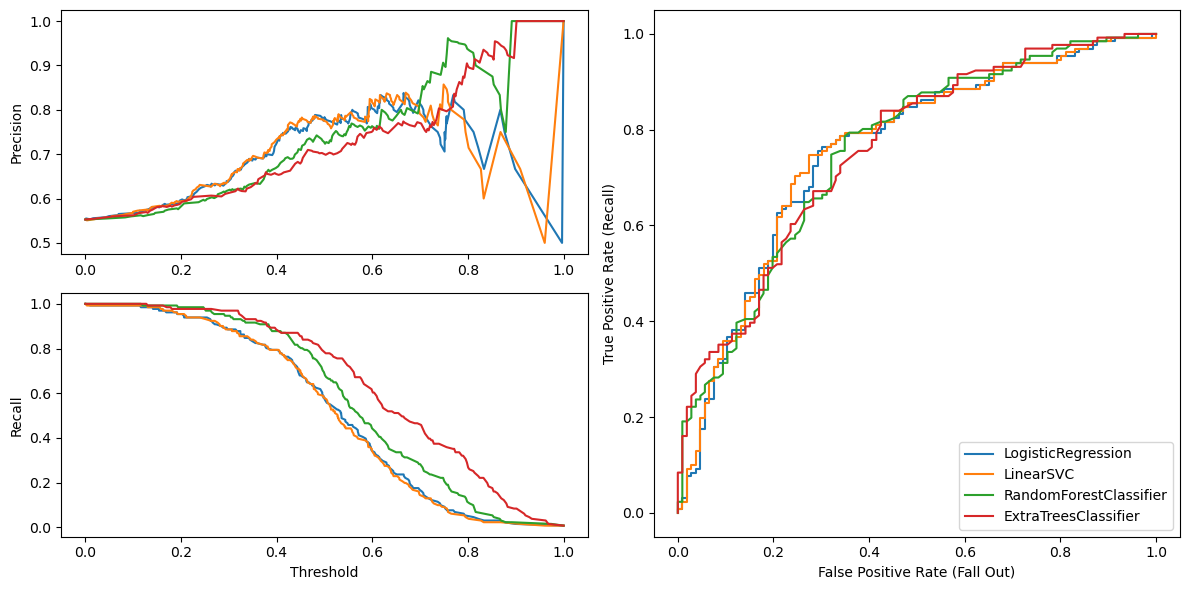

In [469]:
fig = plt.figure(figsize=(12,6))
for model in selected_models:
    #getting scores
    try:
      y_scores = model.decision_function(X_test)
    except:
      y_scores = model.predict_proba(X_test)[:,1]
       
    #cal_mod = CalibratedClassifierCV(model,cv='prefit')
    #cal_mod.fit(X_train, y_train)
    #y_scores = cal_mod.predict_proba(X_test)[:,1] #https://scikit-learn.org/stable/modules/calibration.html

    #calculating precision, recall, false positive rate, true positive rate, and normalizing thresholds
    fpr,tpr,thresholds=roc_curve(y_test, y_scores)
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
    thresholds = (thresholds-min(thresholds))/(max(thresholds)-min(thresholds)) #rescale all thresholds

    #plotitng precision
    plt.subplot(2,2,1)
    plt.plot(thresholds, precisions[:-1],label=type(model).__name__)
    plt.ylabel('Precision')

    #plotting recall
    plt.subplot(2,2,3)
    plt.plot(thresholds, recalls[:-1],label=type(model).__name__)
    plt.ylabel("Recall")
    plt.xlabel("Threshold")
    #plt.legend()

    #plotting ROC#
    ax = plt.subplot(1,2,2)
    plt.plot(fpr,tpr,label=type(model).__name__)
    plt.xlabel('False Positive Rate (Fall Out)')
    plt.ylabel('True Positive Rate (Recall)')
    ax.legend(loc=4)
plt.tight_layout()
    

We see that the logistic regression and SVC models have superior precision up to a threshold of 0.6. Past this point, the tree-based classifiers outperform the other models. The AUC ROC is a measure of a classifier’s ability to separate classes. The logistic regression and SVC classifiers have the highest ROC AOC. The advantage of the tree-based classifiers is apparent in the recall curve, where extra trees has a much better recall at all thresholds.

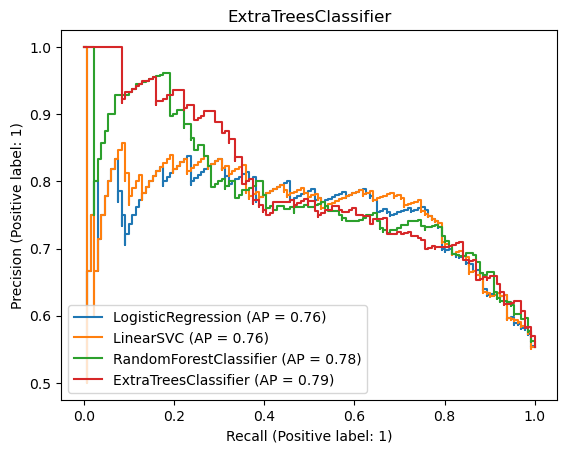

In [470]:


fig, ax = plt.subplots(1)
for model in selected_models:
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax = ax)
    plt.title(type(model).__name__)

Precision vs. recall is plotted at different thresholds. At high thresholds, the tree-based models are much more precise than the other models. Thus, if high precision is needed, it may be advantages to use a tree-based model with a higher threshold. Were this model to be used by clinicians to make predictions directly to patients, high precision may be desirable when telling a patient that they are likely to die from cancer, where as low recall is less important.

### Combining classifiers

The linear SVC classifier performs very well across most metrics including precision, ROC AUC, accuracy and F1 score and is the best single classifier option with an accuracy of 0.73. We combine classifiers into stacking and voting classifiers to improve accuracy beyond what is possible with a single SVC classifier.

In [471]:
stacking_clf = StackingClassifier([
    ('lr', selected_models[0]),
    ('svc', selected_models[1]),
    #('rf', selected_models[2]),
    ('et', selected_models[3])
],
final_estimator= LogisticRegression(random_state=10)
)

In [472]:
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.729957805907173

No improvement is noted with a stacking classifier, even with final estimator optimization and careful selection of included models.

In [473]:
voting_clf = VotingClassifier(estimators=[
    ('lr', selected_models[0]),
    #('svc', selected_models[1]),
    ('rf', selected_models[2]),
    ('et', selected_models[3])
]
)

In [474]:
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7341772151898734

The voting classifier outperformed the linear SVC classifier with an accuracy of 0.734 on the test set. Interestingly, performance is degraded with the inclusion of the SVC classifier. Thus, the voting classifier is used for feature importance selection.

## Feature importance
Feature importances are determined by feature permutation using a permutation importance algorithm from sklearn. In this algorithm, the performance of the model on the test set is used as a baseline. The performance is then measured when each feature is shuffled. The difference in performance with each feature permuted against the baseline is a measure of how important a feature is to the model. The n_repeats parameter sets the number of times a feature is randomly shuffled and in this case we use 30.

In [475]:
f_imp = permutation_importance(voting_clf, X_test, y_test, scoring='accuracy', n_repeats=30,random_state=10)


In [476]:
gene_start = 5
gene_stop = 494
mutant_start = 498
mutant_stop = 553

In [477]:
#f_imps = pd.DataFrame(data=f_imp, index=X_test.columns.values)
#f_imp.sort_values(0,ascending=False).head(20)
f_importance = pd.DataFrame()
f_importance['f_imp'] = f_imp.importances.mean(axis=1)
f_importance['std_error']=f_imp.importances_std/np.sqrt(30)
f_importance.index = X_test.columns.values

f_clinical = f_importance[:gene_start].append(f_importance[mutant_stop:]).append(f_importance[gene_stop:mutant_start]).sort_values('f_imp', ascending=False)
f_genes = f_importance[gene_start:gene_stop].sort_values('f_imp', ascending=False)
f_mutants = f_importance[mutant_start:mutant_stop].sort_values('f_imp', ascending=False)

f_importance = f_importance.sort_values('f_imp', ascending=False)

C:\Users\corne\AppData\Local\Temp\ipykernel_10692\3870551236.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f_clinical = f_importance[:gene_start].append(f_importance[mutant_stop:]).append(f_importance[gene_stop:mutant_start]).sort_values('f_imp', ascending=False)
C:\Users\corne\AppData\Local\Temp\ipykernel_10692\3870551236.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f_clinical = f_importance[:gene_start].append(f_importance[mutant_stop:]).append(f_importance[gene_stop:mutant_start]).sort_values('f_imp', ascending=False)


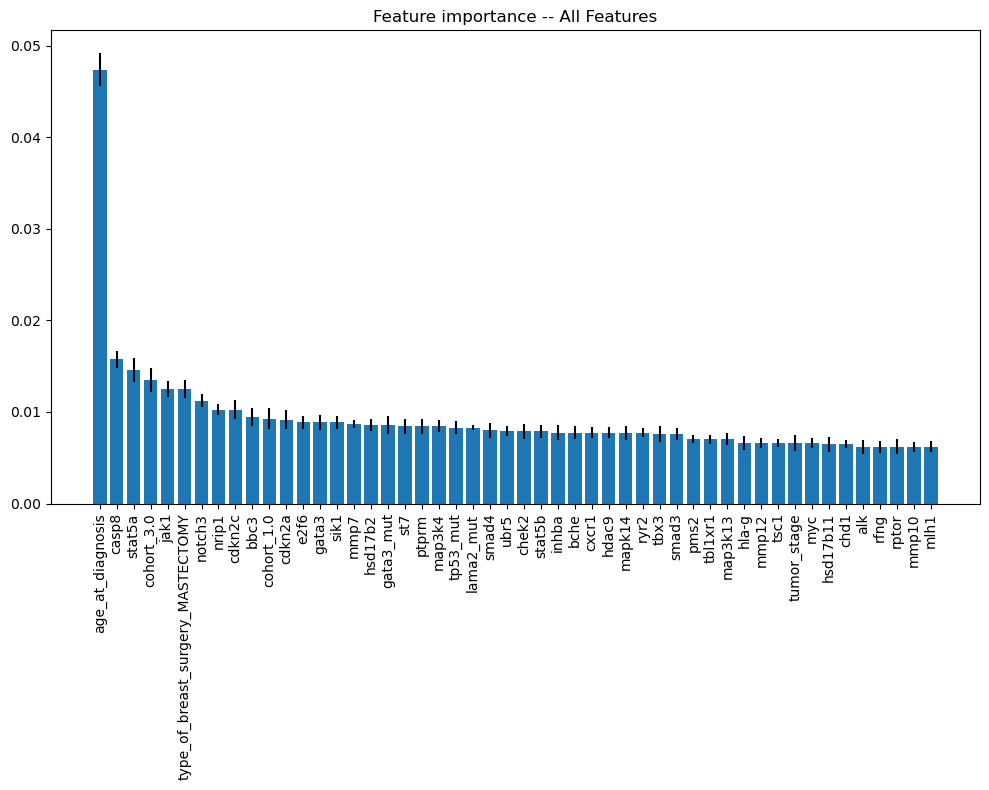

In [478]:
plt.figure(figsize=(10,8))
plt.bar(x=f_importance.index.values[:50], height=f_importance['f_imp'][:50], yerr=f_importance['std_error'][:50])
plt.xticks(rotation=90)
plt.title('Feature importance -- All Features')
plt.tight_layout();

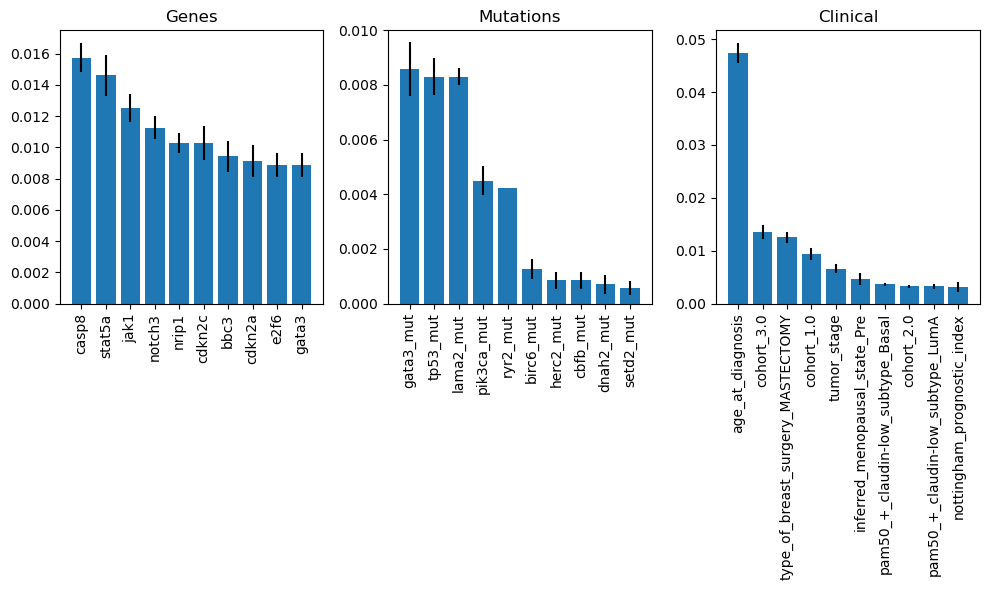

In [479]:
plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
plt.title('Genes')
plt.bar(x=f_genes.index[:10], height=f_genes[:10]['f_imp'],yerr=f_genes[:10]['std_error'])
plt.ylabel = 'Decrease in accuracy'
plt.legend=False
plt.xticks(rotation=90)
plt.subplot(1,3,2)
plt.title('Mutations')
plt.bar(x=f_mutants.index[:10],height=f_mutants[:10]['f_imp'],yerr=f_mutants['std_error'][:10])
plt.ylabel = 'Decrease in accuracy'
plt.legend= legend=False
plt.xticks(rotation=90)
plt.ylim(0,.01)
plt.subplot(1,3,3)
plt.title('Clinical')
plt.bar(x=f_clinical.index[:10],height=f_clinical[:10]['f_imp'],yerr=f_clinical['std_error'][:10])
plt.ylabel = 'Decrease in accuracy'
plt.legend=False
plt.xticks(rotation=90)
plt.tight_layout()

The METABRIC dataset contains m-RNA level z-scores for 331 genes and mutation information for 175 genes. Information on mutations has been condensed to either 0 or 1 for wild or mutant types. We briefly summarize the role of the top 10 genes and mutations that contribute significantly to our model's predictive power. All of the identified genes and mutations are known to contribute to human cancer, which supports the validity of our model. 

<u>Genes</u>
1. CASP8 is an important protein involved in receptor-mediated apoptosis and is affected by estrogen and has been associated with some subtype-specific breast cancers [\[3\]](https://doi.org/10.1186/s12885-015-2036-9).

2. STAT5A plays an important role in chemoresistance [\[4\]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8320598/) in addition to mediating key physiological effects of prolactin and growth hormone in mammary glands [\[5\]](https://breast-cancer-research.biomedcentral.com/articles/10.1186/bcr3328). Even at low levels, Stat5a protein is associated with unfavorable clinical outcomes [\[5\]](https://breast-cancer-research.biomedcentral.com/articles/10.1186/bcr3328).

3. JAK1 is known to work as either an oncogene or a tumor suppressor [\[6\]](https://doi.org/10.18632/aging.102514). Ruxolitinib is an approved JAK inhibitor for targeting and blocking JAK proteins in breast cancer. 

4. NOTCH3 is thought to inhibit breast cancer proliferation and suppress tumorigenesis by transactivating PTEN, a potent tumor suppressor, expression [\[7\]](https://doi.org/10.1038/s41419-021-03735-3).

5. NRIP1 is upregulated in luminal A subtype breast cancers, which have the best prognosis among breast cancer tumors [\[8\]](https://doi.org/10.1038/s41598-021-00291-w).

6. CDKN2C expression has been found to be significantly lower in in breast tumor samples compared with control samples \[[2](https://www.sciencedirect.com/science/article/abs/pii/S2773044122000444)\].

7. BBC3 does not appear to have been studied in the context of breast cancer directly, but has been found to mediate apoptosis and is down-regulated in head and neck tumors \[[8](https://pubmed.ncbi.nlm.nih.gov/23220852/)\]. This is in line with findings that BBC3 contributes to the transduction of diverse cell death and survival signals \[[9](https://www.pnas.org/doi/10.1073/pnas.201208798)\].

8. A genetic variation in the CDKN2A/B gene is associated with increased risk of breast cancer \[[10](https://doi.org/10.1002/jcla.22190)\]. CDK2A is a tumor suppressor gene which confers cancer sensitivity. 

9. E2F6 controls cell proliferation and cell fate. It is thought that E2F6 promotes DNA methylation \[[11](https://doi.org/10.1038/s41467-021-23596-w)\] and has been found to silence a tumor suppressing an RNA gene in ovarian cancers\[[12](https://doi.org/10.1111/cas.13920)\].

<u>Mutations</u>

1. GATA3 is a transcription factor involved in human growth and differentiation and is highly expressed in Luminal A subtype breast cancer and associated with favorable pathologic features \[[13](https://doi.org/10.1158/1055-9965.EPI-06-1090)\].  In fact, GATA3 is mutated in 10-15% of breast tumors and is thought to underly some early onset cancers \[[14](https://doi.org/10.1016/j.sbi.2021.05.015)\]. 

2. TP53 is mutant in 30% of all breast cancers and is the most frequently mutated gene. The role of TP53 in the management of breast cancer remains unclear and can be detrimental or beneficial depending on the treatment given \[[15](https://doi.org/10.1016/j.trecan.2020.01.007)\].

3. LAMA2 provides instructions for making a subunit of laminin proteins, which are essential for regulating cell growth, attachment, and mobility. LAMA2 mutations or expression aberrations, as for other stromal genes, has been repeatedly shown to be associated with a poorer prognosis in breast cancer \[[16](https://doi.org/10.1371/journal.pone.0037646)\].

4. A mutation in the PIK3CA gene can cause cells to divide and replicate uncontrollably and contributes to the growth of many cancers and is found in 40% of advanced HR+/HER2- breast cancers and associated with worse prognosis.  Unique treatments have been approved for treating breast cancer with this mutation, like Piqray which inhibits PI3K \[[17](https://doi.org/10.1007/s10549-005-9048-0)\]. 

5. RYR2 is frequently mutated in breast cancer, and its mutation is related to increased tumor mutation burden and promotes antitumor immunity \[[18](https://pubmed.ncbi.nlm.nih.gov/34888385/)\].

## Conclusions

A stacking classifier was trained to predict cancer patient mortality with an accuracy of 73.4%. Primary classifiers were selected for inclusion in the stacking classifier based on their accuracy, but precision, recall, F1 score and ROC AUC metrics were all considered. High-precision tree-based classifiers with high thresholds are recommended for use by clinicians, while accuracy is recommended as a metric for researchers. 

The importance of features to this model was determined by feature permutation. Several important genetic contributions were identified including CASP8, STAT5A, JAK1, NOTCH3, GATA3, TP53, LAMA2, PIK3CA and RYR2. Differences in the genetic expression of these features has been linked to breast cancer patient outcome in the available literature and supports the validity of our classifier. Additional insight may be provided to researchers from investigating mid-ranking permutation importance features that may still significantly affect cancer subtypes and are less likely to have been studied to the same extent:

In [480]:
f_genes[100:200].index.values

array(['casp7', 'mapk3', 'arid1a', 'frmd3', 'star', 'hsd17b3', 'rbl1',
       'rps6kb2', 'ncoa2', 'e2f3', 'e2f5', 'igf1r', 'lifr', 'nr2f1',
       'opcml', 'prkacg', 'dtx4', 'e2f1', 'arid1b', 'setdb1', 'map3k10',
       'thada', 'aph1b', 'npnt', 'nfkb1', 'cir1', 'ncoa3', 'wfdc2',
       'rheb', 'ncor2', 'stat1', 'shank2', 'ttyh1', 'l1cam', 'dnah2',
       'birc6', 'lfng', 'sbno1', 'gpr32', 'casp10', 'numb', 'cdc25a',
       'mmp16', 'ccnd2', 'stat3', 'mtap', 'fgf1', 'cbfb', 'hsd17b10',
       'rps6ka1', 'map2k2', 'tnk2', 'myo1a', 'ccne1', 'mapk4', 'rps6ka2',
       'dnah5', 'hes1', 'pik3r3', 'gh1', 'rictor', 'kras', 'apc', 'kdm5a',
       'smad2', 'hsd17b14', 'ptk2', 'bcl2', 'ccnb1', 'usp9x', 'bmp7',
       'ugt2b17', 'hsd17b13', 'cyp3a4', 'rdh5', 'or6a2', 'hsd17b8',
       'stab2', 'clk3', 'mmp3', 'smarcc2', 'abcb11', 'mmp17', 'setd2',
       'hey1', 'muc16', 'col12a1', 'vegfb', 'bmpr1a', 'abcb1', 'tubb4a',
       'brca1', 'dll1', 'cul1', 'taf1', 'cdk8', 'notch2', 'rps6kb1',
       'm

Adding additional samples to this METABRIC dataset would enable the examination of genetic mutation type on patient mortality. The examination of each mutant type requires the addition of another dimension, which creates more features than instances in this case.

## Works referenced

1. Burwinkel B, Wirtenberger M, Klaes R, et al. Association of NCOA3 polymorphisms with breast cancer risk. Clin Cancer Res. 2005;11(6):2169-2174. doi:10.1158/1078-0432.CCR-04-1621
2. Rakhshan, A., Gholipour, M., Hussen, B. M., Taheri, M., Eslami, S., Ghafouri-Fard, S., & Asghar Hafez, A. (2022). Expression analysis of CDKN2C-related lncRNAs in breast cancer. Human Gene, 33, 201070.
3. Park, H. L., Ziogas, A., Chang, J., Desai, B., Bessonova, L., Garner, C., Lee, E., Neuhausen, S. L., Wang, S. S., Ma, H., Clague, J., Reynolds, P., Bernstein, L., & Anton-Culver, H. (2015). Novel polymorphisms in caspase-8 are associated with breast cancer risk in the California Teachers Study. BMC Cancer, 16. 
4. Li, Z., Chen, C., Chen, L., Hu, D., Yang, X., Zhuo, W., Chen, Y., Yang, J., Zhou, Y., Mao, M., Zhang, X., Xu, L., Ju, S., Shen, J., Wang, Q., Dong, M., Xie, S., Wei, Q., Jia, Y., Wang, L. (2020). STAT5a Confers Doxorubicin Resistance to Breast Cancer by Regulating ABCB1. Frontiers in Oncology, 11. 
5. Peck, A.R., Witkiewicz, A.K., Liu, C. et al. Low levels of Stat5a protein in breast cancer are associated with tumor progression and unfavorable clinical outcomes. Breast Cancer Res 14, R130 (2012). 
6. Chen, B., Lai, J., Dai, D., Chen, R., Li, X., & Liao, N. (2019). JAK1 as a prognostic marker and its correlation with immune infiltrates in breast cancer. Aging (Albany NY), 11(23), 11124-11135.
7. Zhang, Y., Liang, Y., Wu, Y., Chen, M., Chen, W., Li, R., Zeng, Y., Huang, W., Wu, J., Zeng, D., Gao, W., Chen, C., Lin, H., Yang, R., Zhu, J., Liu, W., Bai, J., Wei, M., Wei, X., Zhang, G. (2021). Notch3 inhibits cell proliferation and tumorigenesis and predicts better prognosis in breast cancer through transactivating PTEN. Cell Death & Disease, 12(6), 1-16. 
8. Binato, R., Corrêa, S., Panis, C., Ferreira, G., Petrone, I., da Costa, I. R., & Abdelhay, E. (2021). NRIP1 is activated by C-JUN/C-FOS and activates the expression of PGR, ESR1 and CCND1 in luminal A breast cancer. Scientific Reports, 11(1), 1-12
9. Tajnik M, Stražišar M, Volavšek M, Boštjančič E, Glavač D. BBC3 is down-regulated with increased tumor size independently of p53 expression in head and neck cancer. Cancer Biomark. 2012;11(5):197-208. 
10. ShahidSales, S., Mehramiz, M., Ghasemi, F., Aledavood, A., Shamsi, M., Hassanian, S. M., & Avan, A. (2018). A genetic variant in CDKN2A/B gene is associated with the increased risk of breast cancer. Journal of Clinical Laboratory Analysis, 32(1). 
11. Dahlet, T., Truss, M., Frede, U., Al Adhami, H., Bardet, A. F., Dumas, M., Vallet, J., Chicher, J., Hammann, P., Kottnik, S., Hansen, P., Luz, U., Alvarez, G., Auclair, G., Hecht, J., Robinson, P. N., Hagemeier, C., & Weber, M. (2021). E2F6 initiates stable epigenetic silencing of germline genes during embryonic development. Nature Communications, 12(1), 1-14.
12. C. Cheng, F. H., Lin, Y., Hwang, W., Chen, C., Huang, L., Chang, B., Yang, W., Lin, I., Lin, W., W. Chen, G. C., Mai, Y., J. Lin, J. M., Chuang, M., Chou, L., Kuo, W., Li, C., L. Cheng, A. S., Lai, C., Wu, F., . . . Y. Chan, M. W. (2019). E2F6 functions as a competing endogenous RNA, and transcriptional repressor, to promote ovarian cancer stemness. Cancer Science, 110(3), 1085-1095.
13. Voduc, D., Cheang, M., & Nielsen, T. (2008). GATA-3 expression in breast cancer has a strong association with estrogen receptor but lacks independent prognostic value. Cancer epidemiology, biomarkers & prevention : a publication of the American Association for Cancer Research, cosponsored by the American Society of Preventive Oncology, 17(2), 365–373.
14. Martin, E. M., Orlando, K. A., Yokobori, K., & Wade, P. A. (2021). The estrogen receptor/GATA3/FOXA1 transcriptional network: Lessons learned from breast cancer. Current Opinion in Structural Biology, 71, 65-70.
15. Shahbandi, A., Nguyen, H.D., Jackson, J.G. (2020). TP53 Mutations and Outcomes in Breast Cancer: Reading beyond the Headlines. Trends in Cancer, 6,3,98-110.
16. Mefford, D., & Mefford, J. (2012). Stromal Genes Add Prognostic Information to Proliferation and Histoclinical Markers: A Basis for the Next Generation of Breast Cancer Gene Signatures. PLOS ONE, 7(6), e37646.
17. Li, S.Y., Rong, M., Grieu, F. et al. (2006). PIK3CA mutations in breast cancer are associated with poor outcome. Breast Cancer Res Treat 96, 91–95.
18. Xu, Z., Xiang, L., Wang, R., Xiong, Y., Zhou, H., Gu, H., Wang, J., Peng, L. (2021). Bioinformatic Analysis of Immune Significance of RYR2 Mutation in Breast Cancer. Biomed Res Int 8072796.